<a href="https://colab.research.google.com/github/jahanshukhy/Intro-to-Machine-Learning/blob/main/HW7_prb1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Imports & device
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

In [15]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [16]:
# Download CIFAR-10, convert to tensor and normalize

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616]
    ),
])

data_path = './data-cifar10/'

cifar10_train = datasets.CIFAR10(
    root=data_path, train=True, download=True, transform=transform
)

cifar10_val = datasets.CIFAR10(
    root=data_path, train=False, download=True, transform=transform
)

trainloader = DataLoader(cifar10_train, batch_size=128, shuffle=True)
valloader   = DataLoader(cifar10_val,   batch_size=128, shuffle=False)

print("Train size:", len(cifar10_train))
print("Val size  :", len(cifar10_val))


Train size: 50000
Val size  : 10000


In [17]:
# CNN Model

class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution layer 1
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Convolution layer 2
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)

        # Convolution layer 3
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # After 3 poolings: 32 -> 16 -> 8 -> 4
        self.fc1 = nn.Linear(32 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 3→8, pool 32→16
        x = self.pool(F.relu(self.conv2(x)))   # 8→16, pool 16→8
        x = self.pool(F.relu(self.conv3(x)))   # 16→32, pool 8→4
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [18]:
# Initialize Model, Loss, Optimizer

model = CNN_Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model Size (Trainable Parameters): {total_params}")
    return total_params

In [19]:
# Training Function

def train_model(num_epochs=300):

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for imgs, labels in trainloader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss_epoch = running_loss / len(trainloader)
        train_acc_epoch = correct / total

        train_losses.append(train_loss_epoch)
        train_accuracies.append(train_acc_epoch)

        # Validation loop
        model.eval()
        v_loss = 0.0
        v_correct = 0
        v_total = 0

        with torch.no_grad():
            for imgs, labels in valloader:
                imgs, labels = imgs.to(device), labels.to(device)

                outputs = model(imgs)
                loss = criterion(outputs, labels)

                v_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                v_total += labels.size(0)
                v_correct += (predicted == labels).sum().item()

        val_loss_epoch = v_loss / len(valloader)
        val_acc_epoch  = v_correct / v_total

        val_losses.append(val_loss_epoch)
        val_accuracies.append(val_acc_epoch)


        epoch_time = time.time() - start_time

        print(f"Epoch {epoch+1:4d} | "
              f"Time: {epoch_time:6.2f} s | "
              f"Train loss: {train_loss_epoch:.4f} | "
              f"Val loss: {val_loss_epoch:.4f} | "
              f"Train acc: {train_acc_epoch:.4f} | "
              f"Val acc: {val_acc_epoch:.4f}")


    total_time = time.time() - start_time
    print(f"\nTraining finished in {total_time/60:.2f} minutes.")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [20]:
# Plotting Function

def plot_curves(train_losses, val_losses, train_acc, val_acc):

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 12))

    # training vs validation loss plot
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, label="Train loss")
    plt.plot(epochs, val_losses, label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    # training vs validation accuracy plot
    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_acc, label="Train accuracy")
    plt.plot(epochs, val_acc, label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()




--- MODEL SIZE ---
Model Size (Trainable Parameters): 39514

--- TRAINING ---
Epoch    1 | Time:  33.77 s | Train loss: 1.6733 | Val loss: 1.4312 | Train acc: 0.3897 | Val acc: 0.4776
Epoch    2 | Time:  67.84 s | Train loss: 1.3523 | Val loss: 1.2741 | Train acc: 0.5151 | Val acc: 0.5360
Epoch    3 | Time: 103.46 s | Train loss: 1.2190 | Val loss: 1.1837 | Train acc: 0.5665 | Val acc: 0.5773
Epoch    4 | Time: 137.44 s | Train loss: 1.1301 | Val loss: 1.1138 | Train acc: 0.6018 | Val acc: 0.6005
Epoch    5 | Time: 170.86 s | Train loss: 1.0642 | Val loss: 1.0718 | Train acc: 0.6255 | Val acc: 0.6208
Epoch    6 | Time: 205.22 s | Train loss: 1.0119 | Val loss: 1.0235 | Train acc: 0.6448 | Val acc: 0.6429
Epoch    7 | Time: 237.98 s | Train loss: 0.9697 | Val loss: 1.0021 | Train acc: 0.6605 | Val acc: 0.6506
Epoch    8 | Time: 271.85 s | Train loss: 0.9340 | Val loss: 0.9862 | Train acc: 0.6729 | Val acc: 0.6581
Epoch    9 | Time: 305.15 s | Train loss: 0.9034 | Val loss: 0.9781 | Tra

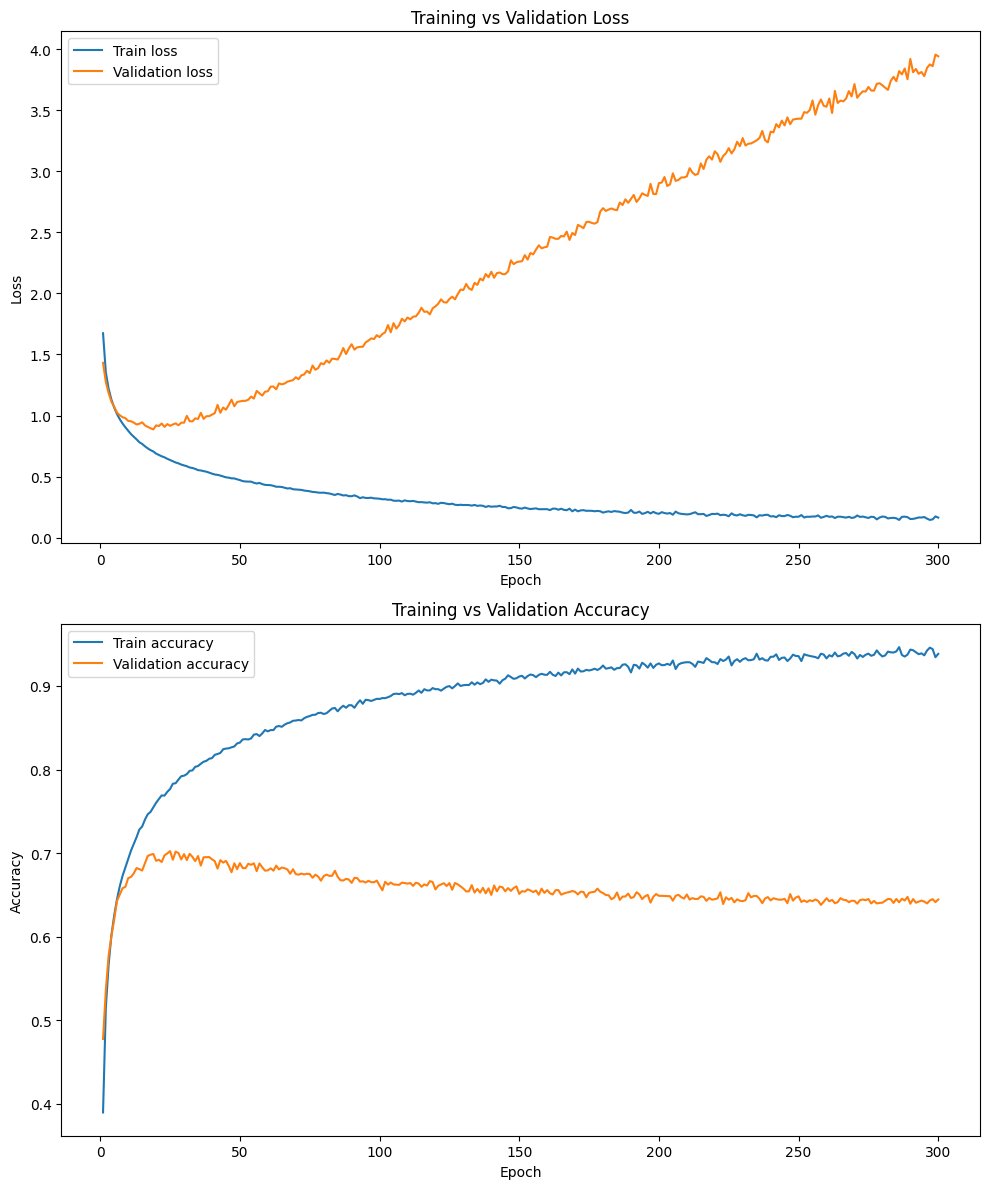

In [21]:
if __name__ == "__main__":

    print("\n--- MODEL SIZE ---")
    count_parameters(model)

    print("\n--- TRAINING ---")
    train_losses, val_losses, train_acc, val_acc = train_model(num_epochs=300)

    print("\n--- PLOTTING ---")
    plot_curves(train_losses, val_losses, train_acc, val_acc)
